# Capstone Project - The Battle of Neighborhoods (Week 1)

## Introduction / Business Problem

When visiting a major city in another country for a short period, it can be difficult to establish the orientation and location of interesting  “neighbourhoods”.  Unless aided by friends or family who know the destination city well, it is common to get stuck in the tourist quarters, and miss the vibrancy of each city’s more interesting parts. In London, where I live, tourists are rarely seen outside of relatively few and relatively central locations: Westminster, the West End, the South Bank, and Shoreditch.  This could be partly due to the contrivances of guide books and partly due to the overwhelming size of modern cities. 

To get a sense of what each neighbourhood in a destination city is like, it can be useful to “translate” their characteristics to a more familiar place. For example, Peckham and Brooklyn are more similar than, say, Peckham and Midtown, which would be a helpful orientation device for a native Londoner (particularly if they are in search of craft beer and hipsters).

A similar problem is contemplated by the site Hoodmaps ([https://hoodmaps.com](https://hoodmaps.com/)), which relies on a crowdsourcing technique to characterise the neighbourhoods of cities around the world.  This is a really interesting approach, however, I propose a different approach, leveraging existing location data, such as venue-related data offered via the Foursquare API, which would be interesting to tourists.  By building a venue-based profile for each neighbourhood in a number of cities, it would be possible to employ a clustering approach across cities to identify similarities in neighbourhoods based on the venue types located there.

To test this concept, I will use three major cities, about which there will be sufficiently large datasets available: London, New York, and Paris.  I have selected these cities, as I have first-hand experience of spending significant periods of time in each, and can compare the results with the “ground truth”, given that clustering will be unsupervised without a formal evaluation technique.

## Data

The data about the neighbourhoods will be sourced through two means:

1. First, we need to partition each city into identifiable neighbourhoods, and obtain geographic coordinates for the centre of each.  We will explore the use of postal / zip codes to do this initial partitioning.  We will present the results of this on a map for each city. 
    - New York: [https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm](https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm)
    - London: [https://www.milesfaster.co.uk/london-postcodes-list.htm](https://www.milesfaster.co.uk/london-postcodes-list.htm)
    - Paris: [https://www.worldpostalcodes.org/en/france/arrondissement/map-of-postal-codes-in-paris](https://www.worldpostalcodes.org/en/france/arrondissement/map-of-postal-codes-in-paris)
2. For each neighbourhood in each of the three cities, and using the coordinates obtained for each, we will identify the principal venue types based on their frequency of occurrence using the Foursquare API.  

We will assess various clustering techniques, using the Scikit-learn library, to then segment neighbourhoods and identify similar neighbourhoods across the three cities.

## Analysis

In [17]:
import json
import pickle

import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import geocoder

#### Import Config

In [2]:
with open('config.p', 'rb') as pfile:
    config = pickle.load(pfile)

In [3]:
def get_table_from_url(url, table_index=0):
    rv = requests.get(url)
    if rv.ok:
        html = rv.content
        soup = BeautifulSoup(html, 'html.parser')
        table = soup.find_all('table')[table_index]
        return str(table)
    return None

#### NEW YORK

In [4]:
# Get neighborhoods
ny_url = 'https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm'

df_ny = pd.read_html(get_table_from_url(ny_url))[0]

# reformat / drop / add city code
df_ny.drop(columns=['Borough'], inplace=True)
df_ny.columns = ['locale', 'zip']
df_ny['city'] = 'New York City, New York, USA'
df_ny['city_code'] = 'NYC'

In [5]:
df_ny.head()

,locale,zip,city,city_code
0,Central Bronx,"10453, 10457, 10460","New York City, New York, USA",NYC
1,Bronx Park and Fordham,"10458, 10467, 10468","New York City, New York, USA",NYC
2,High Bridge and Morrisania,"10451, 10452, 10456","New York City, New York, USA",NYC
3,Hunts Point and Mott Haven,"10454, 10455, 10459, 10474","New York City, New York, USA",NYC
4,Kingsbridge and Riverdale,"10463, 10471","New York City, New York, USA",NYC


In [6]:
def flatten_zips(data):
    flattened = []
    for l in data:
        zips = tuple(l['zip'].split(','))
        for z in zips:
            item = {
                'zip': z,
                'locale': l['locale'],
                'city': l['city'],
                'city_code': l['city_code']
            }
            flattened.append(item)
    return flattened
    

In [7]:
flattened_ny_data = flatten_zips(df_ny.to_dict(orient='records'))

In [8]:
df_ny = pd.DataFrame(flattened_ny_data)

In [9]:
df_ny

,zip,locale,city,city_code
0,10453,Central Bronx,"New York City, New York, USA",NYC
1,10457,Central Bronx,"New York City, New York, USA",NYC
2,10460,Central Bronx,"New York City, New York, USA",NYC
3,10458,Bronx Park and Fordham,"New York City, New York, USA",NYC
4,10467,Bronx Park and Fordham,"New York City, New York, USA",NYC
...,...,...,...,...
173,10312,South Shore,"New York City, New York, USA",NYC
174,10301,Stapleton and St. George,"New York City, New York, USA",NYC
175,10304,Stapleton and St. George,"New York City, New York, USA",NYC
176,10305,Stapleton and St. George,"New York City, New York, USA",NYC


#### LONDON

In [10]:
ld_url = 'https://www.milesfaster.co.uk/london-postcodes-list.htm'

df_ld = pd.read_html(get_table_from_url(ld_url))[0]

# london table is two sets of two columns - need to cut table in half and create union

df_ld.columns = ['zip1','locale1','zip2','locale2']

df_ld_parta = df_ld[['zip1','locale1']]
df_ld_partb = df_ld[['zip2','locale2']]

df_ld_parta.columns = ['zip','locale']
df_ld_partb.columns = ['zip','locale']

ld_combined = df_ld_parta.to_dict(orient='record') + df_ld_partb.to_dict(orient='record')

df_ld = pd.DataFrame(ld_combined)
df_ld.dropna(inplace=True)
df_ld['city'] = 'London, UK'
df_ld['city_code'] = 'LDN'

/Users/paulmclear/.virtualenvs/data_science/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(


In [11]:
df_ld

,zip,locale,city,city_code
0,E1,"Whitechapel, Stepney, Mile End","London, UK",LDN
1,E1W,Wapping,"London, UK",LDN
2,E2,"Bethnal Green, Shoreditch","London, UK",LDN
3,E3,"Bow, Bromley-by-Bow","London, UK",LDN
4,E4,"Chingford, Highams Park","London, UK",LDN
...,...,...,...,...
123,W10,"Ladbroke Grove, North Kensington","London, UK",LDN
124,W11,"Notting Hill, Holland Park","London, UK",LDN
125,W12,Shepherds Bush,"London, UK",LDN
126,W13,West Ealing,"London, UK",LDN


#### PARIS

In [12]:
pa_url = 'https://www.worldpostalcodes.org/en/france/arrondissement/map-of-postal-codes-in-paris'

df_pa = pd.read_html(get_table_from_url(pa_url, table_index=22))[0]

# reformat 
df_pa.dropna(inplace=True)

cols_to_drop = [n for i, n in enumerate(df_pa.columns) if i > 1]
df_pa.drop(columns=cols_to_drop, inplace=True)

df_pa.columns = ['zip', 'locale']
df_pa['city'] = 'Paris, France'
df_pa['city_code'] = 'PAR'
df_pa['zip'] = df_pa['zip'].astype(int)

df_pa.head()

,zip,locale,city,city_code
0,75001,1er Arrondissement Paris,"Paris, France",PAR
1,75002,2ème Arrondissement Paris,"Paris, France",PAR
2,75003,3ème Arrondissement Paris,"Paris, France",PAR
3,75004,4ème Arrondissement Paris,"Paris, France",PAR
4,75005,5ème Arrondissement Paris,"Paris, France",PAR


#### Combine all frames into one

In [13]:
frames = [df_ld,df_ny,df_pa]
df = pd.concat(frames)

In [378]:
locale_city_map = {x['locale']: x['city_code'] for x in df[['locale', 'city_code']].to_dict(orient='record')}

zip_city_map = {x['zip']: x['city_code'] for x in df[['zip', 'city_code']].to_dict(orient='record')}

zip_locale_map = {x['zip']: x['locale'] for x in df[['zip', 'locale']].to_dict(orient='record')}

/Users/paulmclear/.virtualenvs/data_science/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(


In [372]:
df[['city_code','locale']].groupby('city_code').count()

,locale
city_code,
LDN,45
NYC,45
PAR,19


### Apply Coords from Postcode

In [147]:
def get_coords_from_address(string_address):
    point = geocoder.bing(string_address, key=config['bing']['api_key'])
    lat = point.geojson['features'][0]['properties']['lat']
    lng = point.geojson['features'][0]['properties']['lng']
    return {'lat': lat, 'lng': lng}

In [221]:
def get_coords_from_postalcode(row):
    
    if row['city_code'] == 'NYC':
        postal_code, city = row['locale'], f'New York, {row["zip"]}'
    else:
        postal_code, city = row['zip'], row['city']
    
    g = geocoder.bing('{}, {}'.format(postal_code, city), key=config['bing']['api_key'])
    if g.geojson['features']:
        return g.geojson['features'][0]['properties']['lat'], g.geojson['features'][0]['properties']['lng']
    else:
        print('Error on {}'.format(postal_code))
        return 'error'

In [222]:
df['lat'], df['lng'] = zip(*df.apply(get_coords_from_postalcode, axis=1))

In [223]:
df.to_csv('locales_with_coords.csv')

In [320]:
df = pd.read_csv('locales_with_coords.csv')

if 'old_index' in df.columns:
    df.drop(columns=['old_index'], inplace=True)
    
if 'dist_to_centre' in df.columns:
    df.drop(columns=['dist_to_centre'], inplace=True)

In [321]:
df.head()

,zip,locale,city,city_code,lat,lng
0,E1,"Whitechapel, Stepney, Mile End","London, UK",LDN,51.518017,-0.057274
1,E1W,Wapping,"London, UK",LDN,51.506817,-0.059436
2,E2,"Bethnal Green, Shoreditch","London, UK",LDN,51.529713,-0.061366
3,E3,"Bow, Bromley-by-Bow","London, UK",LDN,51.527874,-0.023261
4,E4,"Chingford, Highams Park","London, UK",LDN,51.500153,-0.126236


### Calculate Distance to Centre

In [322]:
centres = {
    'LDN': get_coords_from_address('London, United Kingdom'),
    'NYC': get_coords_from_address('Central Park, New York City, New York, USA'),
    'PAR': get_coords_from_address('Paris, France')
}

In [323]:
centres

{'LDN': {'lat': 51.500152587890625, 'lng': -0.12623600661754608},
 'NYC': {'lat': 40.71304702758789, 'lng': -74.00723266601562},
 'PAR': {'lat': 48.856895446777344, 'lng': 2.350848913192749}}

In [324]:
from sklearn.metrics.pairwise import haversine_distances
from math import radians

def distance_between(origin, destin):
    origin_radians = [radians(_) for _ in origin]
    destin_radians = [radians(_) for _ in destin]
    result = haversine_distances([origin_radians, destin_radians])
    return result * 6371000/1000  # multiply by Earth radius to get kilometers

def distance_row(row):
    origin = (row['lat'], row['lng'])
    city_code = row['city_code']
    destin = (centres[city_code]['lat'], centres[city_code]['lng'])
    return distance_between(origin, destin)[0][1]

In [325]:
if 'dist_to_centre' in df.columns:
    df.drop(columns=['dist_to_centre'], inplace=True)

df['dist_to_centre'] = df.apply(distance_row, axis=1)

In [326]:
df.groupby('city').mean()

,lat,lng,dist_to_centre
city,,,
"London, UK",51.503456,-0.115477,6.727834
"New York City, New York, USA",40.725226,-73.924502,12.165713
"Paris, France",48.859769,2.335257,2.799688


In [327]:
# drop locales from NYC which are not within the city & take 45 most central
df.drop(df[(df['city_code'] == 'NYC') & (df['dist_to_centre'] == 0)].index, inplace=True)
df.drop(df[df['city_code'] == 'NYC'].sort_values('dist_to_centre',ascending=True)[45:].index, inplace=True)

# drop locales from London except most central 45
df.drop(df[df['city_code'] == 'LDN'].sort_values('dist_to_centre',ascending=True)[45:].index, inplace=True)

In [328]:
df.groupby('city').mean()

,lat,lng,dist_to_centre
city,,,
"London, UK",51.499161,-0.129532,3.917131
"New York City, New York, USA",40.727045,-73.976826,5.035211
"Paris, France",48.859769,2.335257,2.799688


In [329]:
df.groupby('city_code').count()['locale']

city_code
LDN    45
NYC    45
PAR    19
Name: locale, dtype: int64

## Draw Base Maps

In [330]:
import folium

In [331]:
def draw_points(map_, frame):
    for lat, lng, locale in zip(frame['lat'], frame['lng'], frame['locale']):
        label = '{}'.format(locale)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_)
    return map_

### London

In [332]:
ld_map = folium.Map(location=[centres['LDN']['lat'], centres['LDN']['lng']], zoom_start=11)
ld_map = draw_points(ld_map, df[df['city_code'] == 'LDN'])

In [415]:
ld_map

### New York

In [334]:
ny_map = folium.Map(location=[centres['NYC']['lat'], centres['NYC']['lng']], zoom_start=11)
ny_map = draw_points(ny_map, df[df['city_code'] == 'NYC'])

In [335]:
ny_map

### Paris

In [336]:
pa_map = folium.Map(location=[centres['PAR']['lat'], centres['PAR']['lng']], zoom_start=11)
pa_map = draw_points(pa_map, df[df['city_code'] == 'PAR'])

In [337]:
pa_map

## Collect Venue Data

In [338]:
CLIENT_ID = config['four_square']['client_id'] # your Foursquare ID
CLIENT_SECRET = config['four_square']['client_secret'] # your Foursquare Secret
VERSION = '20201208' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
RADIUS = 500

In [352]:
def get_venues(neighborhoods, radius=RADIUS, limit=LIMIT):
    
    venues_list=[]
    
    for zip_, city_code, name, lat, lng in neighborhoods:            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}\
            &client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        try:
            results = requests.get(url).json()['response']['groups'][0]['items']
            
            if len(results) == 0:
                print('WARNING! Neighborhood {} returned 0 results'.format(name))
        
            # return only relevant information for each nearby venue
            venues_list.append([(
                zip_,
                city_code,
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
            
        except KeyError as error:
            print(name)
            print(error)
        
        

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['zip',
                             'city_code',
                             'n_name', 
                              'n_lat', 
                              'n_lng', 
                              'v_name', 
                              'v_lat', 
                              'v_lng', 
                              'v_cat']
    
    return(nearby_venues)

In [353]:
data = df[['zip','city_code', 'locale', 'lat', 'lng']].to_dict(orient='records')
data_as_tuples = [tuple(v for k,v in d.items()) for d in data]

venues = get_venues(data_as_tuples)

In [354]:
# save venues data
with open('venues.p', 'wb') as f:
    pickle.dump(venues, f)

with open('venues.json', 'w') as f:
    f.write(venues.to_json(orient='records', indent=4))

In [355]:
print('There are {} uniques categories.'.format(len(venues['v_cat'].unique())))

There are 375 uniques categories.


In [356]:
# restore venues data
with open('venues.p', 'rb') as f:
    venues = pickle.load(f)

In [364]:
# one hot encoding
onehot = pd.get_dummies(venues[['v_cat']], prefix='', prefix_sep='')

# add city and locale columns back to dataframe
onehot['zip'] = venues['zip']
onehot['city_code'] = venues['city_code']
onehot['locale'] = venues['n_name'] 

In [365]:
# move locale column to the first column
fixed_columns = [onehot.columns[-3],onehot.columns[-2],onehot.columns[-1]] + list(onehot.columns[:-3])
onehot = onehot[fixed_columns]

In [367]:
df_grouped = onehot.groupby('zip').mean().reset_index()

In [379]:
df_grouped['city_code'] = df_grouped['zip'].map(zip_city_map)
df_grouped['locale'] = df_grouped['zip'].map(zip_locale_map)

In [380]:
df_grouped.head()

,zip,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auvergne Restaurant,BBQ Joint,Bagel Shop,Baggage Locker,Bakery,Bank,Bar,Baseball Stadium,Basketball Court,Basketball Stadium,Basque Restaurant,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Canal,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Ch'ti Restaurant,Cha Chaan Teng,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Quad,Colombian Restaurant,Comedy Club,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cooking School,Corsican Restaurant,Cosmetics Shop,Coworking Space,Creperie,Cricket Ground,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,...,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Photography Lab,Physical Therapist,Pie Shop,Pier,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Post Office,Pub,Public Art,Racecourse,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Restaurant,River,Road,Rock Climbing Spot,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Salvadoran Restaurant,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Social Club,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Southwestern French Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Stationery Store,Steakhouse,Street Food Gathering,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Synagogue,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Tour Provider,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Travel Lounge,Tree,Turkish Restaurant,Udon Restaurant,University,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Watch Shop,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo Exhibit,city_code,locale
0,10003,0.0,0.0,0.0,0.0,0.0,0.020202,0.0,0.0,0.0,0.000000,0.030303,0.0,0.0,0.030303,0.0,0.00,0.010101,0.010101,0.0,0.0,0.0,0.010101,0.0,0.030303,0.010101,0.060606,0.0,0.0,0.0,0.0,0.0,0.010101,

In [381]:
df_grouped.groupby('city_code').count()

,zip,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auvergne Restaurant,BBQ Joint,Bagel Shop,Baggage Locker,Bakery,Bank,Bar,Baseball Stadium,Basketball Court,Basketball Stadium,Basque Restaurant,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Canal,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Ch'ti Restaurant,Cha Chaan Teng,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Quad,Colombian Restaurant,Comedy Club,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cooking School,Corsican Restaurant,Cosmetics Shop,Coworking Space,Creperie,Cricket Ground,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,...,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Photography Lab,Physical Therapist,Pie Shop,Pier,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Post Office,Pub,Public Art,Racecourse,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Restaurant,River,Road,Rock Climbing Spot,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Salvadoran Restaurant,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Social Club,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Southwestern French Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Stationery Store,Steakhouse,Street Food Gathering,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Synagogue,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Tour Provider,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Travel Lounge,Tree,Turkish Restaurant,Udon Restaurant,University,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Watch Shop,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo Exhibit,locale
city_code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [382]:
import random

cat = random.choice(df_grouped.columns)
print(cat)

Massage Studio


In [383]:
df_grouped[df_grouped[cat] > 0][['city_code','locale', cat]].sort_values(cat, ascending=False)

,city_code,locale,Massage Studio
102,LDN,"Notting Hill, Holland Park",0.016949
23,NYC,Northwest Queens,0.016129
24,NYC,Northwest Brooklyn,0.014085
5,NYC,Chelsea and Clinton,0.010000
13,NYC,Gramercy Park and Murray Hill,0.010000


In [384]:
df_city = df_grouped.groupby('city_code').sum().T

In [385]:
def present_count(row):
    count = 0
    for c in row:
        if c > 0:
            count += 1
    return count
    

In [386]:
df_city['present_in'] = df_city.apply(present_count, axis=1)

In [387]:
df_city['present_in'].value_counts()

1    158
3    118
2     99
Name: present_in, dtype: int64

In [388]:
comparator_cats = df_city[df_city['present_in'] > 1].reset_index()['index'].to_list()
cols_to_drop = df_city[df_city['present_in'] == 1].reset_index()['index'].to_list()

In [389]:
df_grouped.shape

(109, 378)

In [395]:
df_grouped2 = df_grouped.drop(columns=cols_to_drop)

In [396]:
df_grouped2.shape

(109, 220)

In [397]:
df_grouped2.describe().T.sort_values('max', ascending=False).head(10)

,count,mean,std,min,25%,50%,75%,max
French Restaurant,109.0,0.032359,0.061648,0.0,0.000000,0.010000,0.031579,0.369565
Hotel,109.0,0.032458,0.044197,0.0,0.000000,0.021053,0.041096,0.298507
Grocery Store,109.0,0.018937,0.031345,0.0,0.000000,0.010000,0.026667,0.272727
Café,109.0,0.042859,0.046952,0.0,0.012346,0.028986,0.062500,0.266667
Pub,109.0,0.038067,0.052257,0.0,0.000000,0.012346,0.070175,0.264706
Lake,109.0,0.001970,0.019195,0.0,0.000000,0.000000,0.000000,0.200000
Bike Rental / Bike Share,109.0,0.004080,0.019871,0.0,0.000000,0.000000,0.000000,0.200000
Art Gallery,109.0,0.014724,0.036428,0.0,0.000000,0.000000,0.012346,0.186667
Bar,109.0,0.026846,0.032791,0.0,0.000000,0.018868,0.040000,0.150000
Bakery,109.0,0.023713,0.022956,0.0,0.000000,0.020000,0.037037,0.137931


In [399]:
cols = [df_grouped2.columns[-2]] + [df_grouped2.columns[-1]] + list(df_grouped2.columns[:-2])
df_grouped2 = df_grouped2[cols]

In [400]:
df_grouped2.head()

,city_code,locale,zip,Afghan Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bistro,Bookstore,Boutique,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Station,Bus Stop,Café,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Donut Shop,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gastropub,Gay Bar,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Store,Music Venue,Nightclub,Noodle House,North Indian Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Pakistani Restaurant,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Recording Studio,Residential Building (Apartment / Condo),Restaurant,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Snack Place,Social Club,South American Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stationery Store,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tapas Restaurant,Tattoo Parlor,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Train Station,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Waterfront,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,NYC,Lower East Side,10003,0.0,0.020202,0.0,0.0,0.0,0.000000,0.030303,0.0,0.0,0.030303,0.0,0.010101,0.0,0.010101,0.030303,0.060606,0.0,0.010101,0.00,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.010101,0.0,0.0,0.000000,0.050505,0.040404,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.000000,0.0,0.020202,0.0,0.020202,0.0,0.010101,0.010101,0.0,0.00,0.0,0.000000,0.0,0.00,0.0,0.00,0.0,0.010101,0.0,0.0,0.020202,0.000000,0.0,0.010101,0.00,0.010101,0.0,0.020202,0.0,0.0,0.010101,0.010101,0.010101,0.010101,0.000000,0.010101,0.0,0.0,0.0,0.0,0.0,0.010101,0.0,0.0,0.0,0.0,0.000000,0.000000,0.030303,0.00,0.010101,0.0,0.00,0.00,0.00,0.0,0.010101,0.010101,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.010101,0.0,0.0,0.0,0.010101,0.00,0.0,0.030303,0.0,0.0,0.0,0.0,0.0

## Extract Most Common Venue Types

In [401]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[3:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [402]:
num_top_venues = 5
ordinals = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['city_code', 'locale', 'zip']

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{}'.format(ind + 1, ordinals[ind]))
    except:
        columns.append('{}th'.format(ind + 1))

# create a new dataframe
df_venues_sorted = pd.DataFrame(columns=columns)
df_venues_sorted['city_code'] = df_grouped2['city_code']
df_venues_sorted['locale'] = df_grouped2['locale']
df_venues_sorted['zip'] = df_grouped2['zip']

for ind in np.arange(df_grouped2.shape[0]):
    df_venues_sorted.iloc[ind, 3:] = return_most_common_venues(df_grouped2.iloc[ind, :], num_top_venues)


## Cluster Neighborhoods

In [404]:
from sklearn.cluster import KMeans

In [406]:
df_clustering = df_grouped2.drop(columns=['city_code','locale','zip'])
df_clustering.shape

(109, 217)

In [407]:
k = 25

# run k-means clustering
kmeans = KMeans(n_clusters=k, random_state=0).fit(df_clustering)

# add cluster labels
if 'cluster' in df_venues_sorted.columns:
    df_venues_sorted.drop(columns=['cluster'], inplace=True)

df_venues_sorted.insert(0, 'cluster', kmeans.labels_)

<AxesSubplot:xlabel='cluster'>

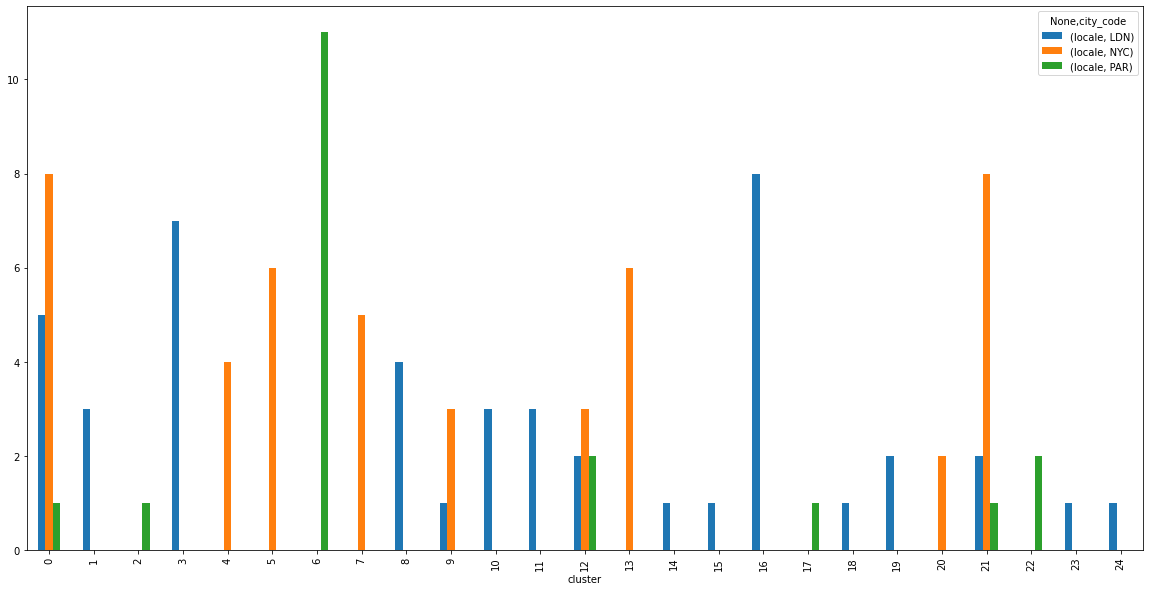

In [408]:
df_venues_sorted[['cluster','city_code','locale']]\
    .pivot_table(index='cluster', columns='city_code', aggfunc='count')\
    .plot(kind='bar', figsize=(20,10))

In [411]:
df_venues_sorted[df_venues_sorted['cluster'] == 0]

,cluster,city_code,locale,zip,1st,2nd,3rd,4th,5th
2,0,NYC,Lower Manhattan,10006,Coffee Shop,Pizza Place,Bar,Memorial Site,Wine Shop
5,0,NYC,Chelsea and Clinton,10011,Coffee Shop,American Restaurant,Gym / Fitness Center,Italian Restaurant,Bakery
14,0,NYC,Upper East Side,10028,Coffee Shop,Café,Art Gallery,Italian Restaurant,Burger Joint
17,0,NYC,Upper East Side,10044,Coffee Shop,Café,Art Gallery,Italian Restaurant,Burger Joint
18,0,NYC,Upper East Side,10065,Coffee Shop,Café,Art Gallery,Italian Restaurant,Burger Joint
19,0,NYC,Upper East Side,10075,Coffee Shop,Café,Art Gallery,Italian Restaurant,Burger Joint
20,0,NYC,Upper East Side,10128,Coffee Shop,Café,Art Gallery,Italian Restaurant,Burger Joint
40,0,NYC,Upper East Side,10021,Coffee Shop,Café,Art Gallery,Italian Restaurant,Burger Joint
47,0,PAR,3ème Arrondissement Paris,75003,Japanese Restaurant,Art Gallery,French Restaurant,Wine Bar,Sandwich Place
78,0,LDN,St Johns Wood,NW8,Café,Coffee Shop,Deli / Bodega,French Restaurant,Yoga Studio


In [413]:
df_venues_sorted[df_venues_sorted['cluster'] == 12]

,cluster,city_code,locale,zip,1st,2nd,3rd,4th,5th
9,12,NYC,Gramercy Park and Murray Hill,10017,Coffee Shop,Japanese Restaurant,French Restaurant,Hotel,Gym
12,12,NYC,Chelsea and Clinton,10020,Theater,Hotel,Steakhouse,French Restaurant,Chocolate Shop
13,12,NYC,Gramercy Park and Murray Hill,10022,Hotel,Coffee Shop,Boutique,French Restaurant,Jewelry Store
45,12,PAR,1er Arrondissement Paris,75001,French Restaurant,Plaza,Clothing Store,Café,Hotel
50,12,PAR,6ème Arrondissement Paris,75006,Plaza,French Restaurant,Italian Restaurant,Wine Bar,Café
100,12,LDN,"Mayfair, Marylebone, Soho",W1,Boutique,Clothing Store,Art Gallery,Dessert Shop,Women's Store
108,12,LDN,"Covent Garden, Holborn, Strand",WC2,Hotel,Theater,Cocktail Bar,Steakhouse,Burger Joint


In [414]:
df_venues_sorted[df_venues_sorted['cluster'] == 21]

,cluster,city_code,locale,zip,1st,2nd,3rd,4th,5th
23,21,NYC,Northwest Queens,11106,Greek Restaurant,Liquor Store,Food Truck,Bagel Shop,Pizza Place
24,21,NYC,Northwest Brooklyn,11205,Mexican Restaurant,Yoga Studio,Wine Shop,Bar,Chinese Restaurant
25,21,NYC,Central Brooklyn,11213,Caribbean Restaurant,Discount Store,Park,Café,Chinese Restaurant
27,21,NYC,Central Brooklyn,11216,Caribbean Restaurant,Coffee Shop,Deli / Bodega,Grocery Store,Bar
30,21,NYC,Greenpoint,11222,Deli / Bodega,Coffee Shop,Sushi Restaurant,Grocery Store,Italian Restaurant
33,21,NYC,Central Brooklyn,11233,Ice Cream Shop,Fast Food Restaurant,Fried Chicken Joint,Indian Restaurant,Health & Beauty Service
41,21,NYC,Northwest Brooklyn,11201,Gym,Bakery,Yoga Studio,Bagel Shop,Grocery Store
43,21,NYC,Greenpoint,11211,Deli / Bodega,Coffee Shop,Sushi Restaurant,Grocery Store,Italian Restaurant
55,21,PAR,12ème Arrondissement Paris,75012,Bistro,Hotel,Supermarket,Chinese Restaurant,French Restaurant
76,21,LDN,"Regents Park, Camden Town",NW1,Coffee Shop,Pub,Pizza Place,Japanese Restaurant,Tea Room
